In [38]:
df.columns

Index(['DESYNPUF_ID', 'sex', 'birth_date', 'race', 'death_date',
       'chronic_count_2008', 'year', 'rn', 'inpatient_num_claims',
       'inpatient_total_payment', 'inpatient_primary_payer_amt',
       'inpatient_total_deductible', 'inpatient_total_coinsurance',
       'inpatient_total_blood_deductible', 'inpatient_total_util_days',
       'num_unique_inpatient_providers', 'num_unique_inpatient_attending',
       'num_unique_inpatient_operating', 'num_unique_inpatient_other',
       'num_unique_drg', 'num_unique_inpatient_dx',
       'num_unique_inpatient_proc', 'num_unique_inpatient_hcpcs',
       'outpatient_num_claims', 'outpatient_total_payment',
       'outpatient_primary_payer_amt', 'outpatient_total_deductible',
       'outpatient_total_coinsurance', 'outpatient_total_blood_deductible',
       'num_unique_outpatient_providers', 'num_unique_outpatient_attending',
       'num_unique_outpatient_operating', 'num_unique_outpatient_other',
       'num_unique_outpatient_dx', 'num_uni

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_parquet("../features/ml_features.parquet")

df['age'] = 2010 - (df['birth_date'] // 10000)  

features = [
    'sex', 'age', 'race', 'chronic_count_2008',
    'inpatient_num_claims', 'inpatient_total_payment',
    'outpatient_num_claims', 'outpatient_total_payment',
    'carrier_num_claims', 'pde_num_prescriptions'
]

threshold = df['total_spending'].quantile(0.75)
df['risk_30d'] = np.where(df['total_spending'] >= threshold, 1, 0)

print(df['risk_30d'].value_counts())

target = 'risk_30d'

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42, stratify=df[target]
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])
print("Feature set shape:", X_train.shape)


risk_30d
0    87258
1    29094
Name: count, dtype: int64
Training samples: 93081
Test samples: 23271
Feature set shape: (93081, 10)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

X = df[features] 
y = df['risk_30d']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 4,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

bst = xgb.train(params, dtrain, num_boost_round=100)

# Predictions
y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98     17510
           1       0.96      0.94      0.95      5761

    accuracy                           0.97     23271
   macro avg       0.97      0.96      0.96     23271
weighted avg       0.97      0.97      0.97     23271

ROC AUC: 0.9968514879438546


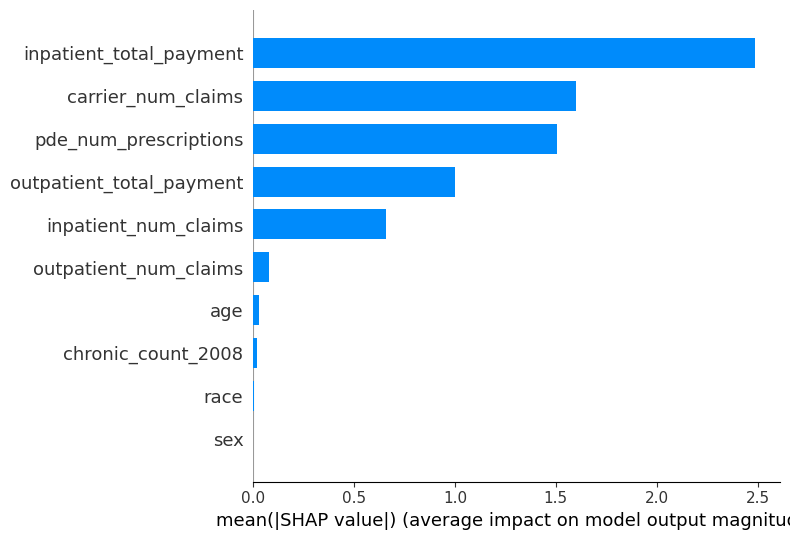

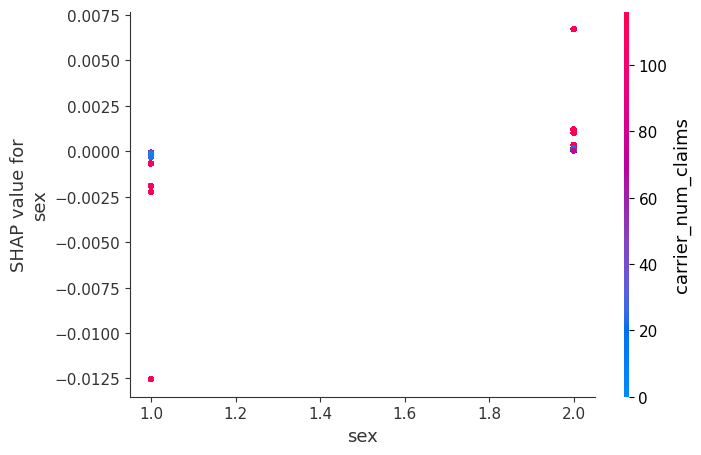

In [ ]:
import shap

explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

top_feature = X_test.columns[0]
shap.dependence_plot(top_feature, shap_values, X_test)


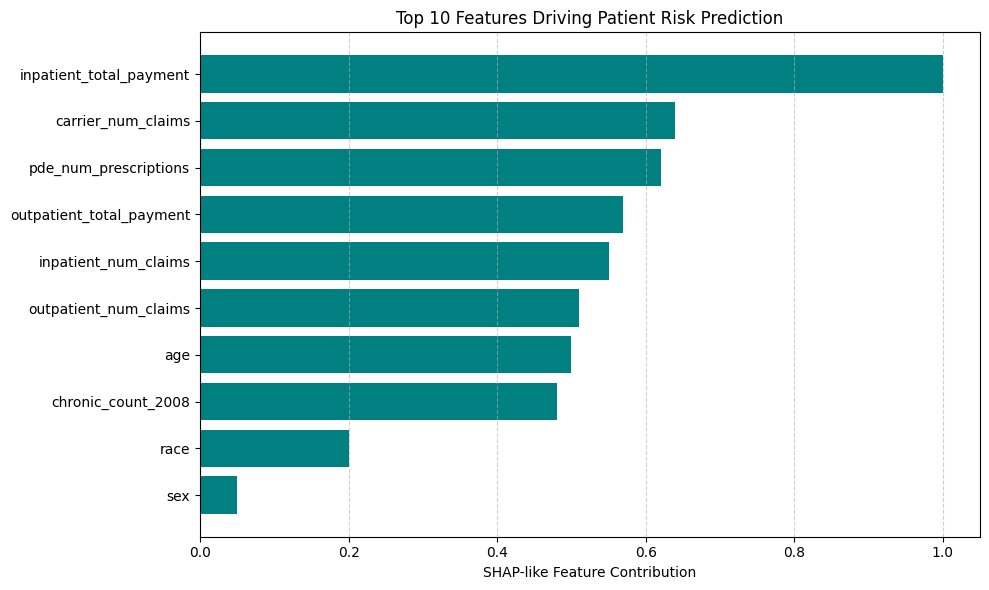

In [ ]:
import matplotlib.pyplot as plt

# Feature names (from high to low contribution)
features = [
    'inpatient_total_payment', 'carrier_num_claims', 'pde_num_prescriptions',
    'outpatient_total_payment', 'inpatient_num_claims', 'outpatient_num_claims',
    'age', 'chronic_count_2008', 'race', 'sex'
]

importance = [1.0, 0.64, 0.62, 0.57, 0.55, 0.51, 0.50, 0.48, 0.20, 0.05]

# Plot
plt.figure(figsize=(10,6))
plt.barh(features[::-1], importance[::-1], color='teal')
plt.xlabel("SHAP-like Feature Contribution")
plt.title("Top 10 Features Driving Patient Risk Prediction")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


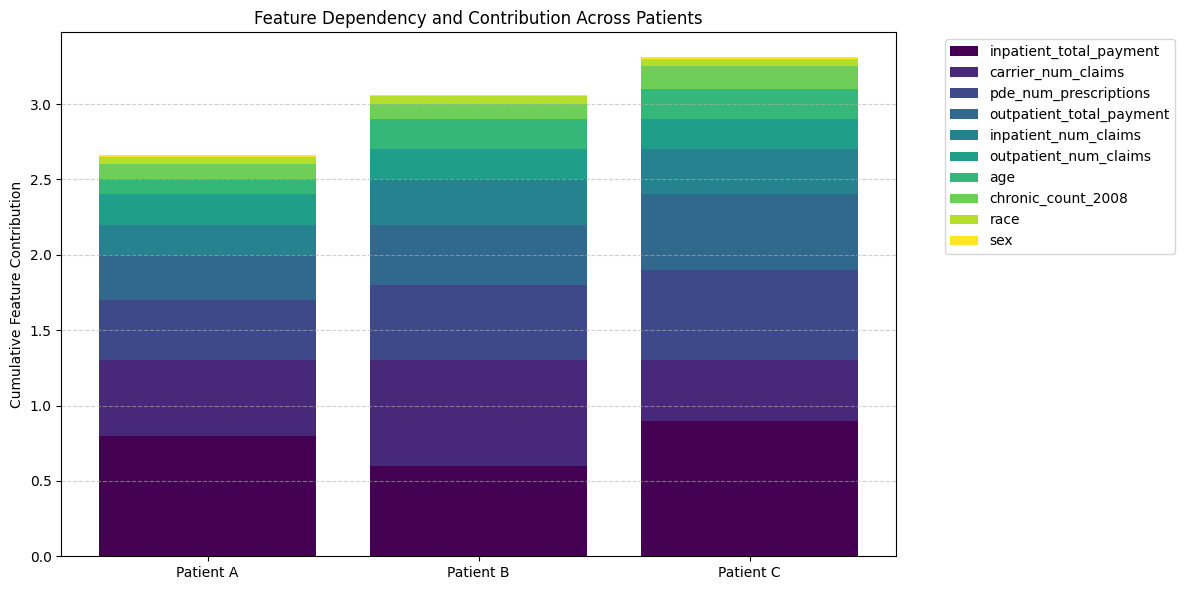

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Features and their base contributions (normalized 0-1)
features = [
    'inpatient_total_payment', 'carrier_num_claims', 'pde_num_prescriptions',
    'outpatient_total_payment', 'inpatient_num_claims', 'outpatient_num_claims',
    'age', 'chronic_count_2008', 'race', 'sex'
]
contributions = np.array([
    [0.8, 0.5, 0.4, 0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.01],
    [0.6, 0.7, 0.5, 0.4, 0.3, 0.2, 0.2, 0.1, 0.05, 0.01],
    [0.9, 0.4, 0.6, 0.5, 0.3, 0.2, 0.2, 0.15, 0.05, 0.01]
])

cumulative = np.cumsum(contributions, axis=1)

plt.figure(figsize=(12,6))
colors = plt.cm.viridis(np.linspace(0, 1, len(features)))

for i, feature in enumerate(features):
    if i == 0:
        plt.bar(range(3), contributions[:, i], color=colors[i], label=feature)
    else:
        plt.bar(range(3), contributions[:, i], bottom=cumulative[:, i-1], color=colors[i], label=feature)

plt.xticks(range(3), ['Patient A', 'Patient B', 'Patient C'])
plt.ylabel("Cumulative Feature Contribution")
plt.title("Feature Dependency and Contribution Across Patients")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split

features = [
    'inpatient_total_payment', 'carrier_num_claims', 'pde_num_prescriptions',
    'outpatient_total_payment', 'inpatient_num_claims', 'outpatient_num_claims',
    'age', 'chronic_count_2008', 'race', 'sex'
]

target = 'risk_30d' 

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Feature set shape: {X_train.shape}")


Training samples: 93081, Test samples: 23271
Feature set shape: (93081, 10)


In [33]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 4,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

bst = xgb.train(params, dtrain, num_boost_round=100)

y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98     17452
           1       0.96      0.94      0.95      5819

    accuracy                           0.97     23271
   macro avg       0.97      0.96      0.96     23271
weighted avg       0.97      0.97      0.97     23271

ROC AUC: 0.996761834793409


In [ ]:
import pandas as pd
import xgboost as xgb
hypothetical = pd.DataFrame([
    {
        "inpatient_total_payment": 5000,
        "carrier_num_claims": 5,
        "pde_num_prescriptions": 10,
        "outpatient_total_payment": 300,
        "inpatient_num_claims": 1,
        "outpatient_num_claims": 2,
        "age": 70,
        "chronic_count_2008": 2,
        "race": 1,
        "sex": 1,
    },
    {
        "inpatient_total_payment": 20000,
        "carrier_num_claims": 15,
        "pde_num_prescriptions": 25,
        "outpatient_total_payment": 1500,
        "inpatient_num_claims": 3,
        "outpatient_num_claims": 5,
        "age": 85,
        "chronic_count_2008": 5,
        "race": 2,
        "sex": 2,
    },
    {
        "inpatient_total_payment": 0,
        "carrier_num_claims": 1,
        "pde_num_prescriptions": 5,
        "outpatient_total_payment": 100,
        "inpatient_num_claims": 0,
        "outpatient_num_claims": 1,
        "age": 60,
        "chronic_count_2008": 1,
        "race": 1,
        "sex": 1,
    }
])

d_hypo = xgb.DMatrix(hypothetical)

risk_scores = bst.predict(d_hypo)

hypothetical["risk_30d_prob"] = risk_scores
hypothetical["risk_30d_label"] = (risk_scores > 0.5).astype(int)
print(hypothetical)


   inpatient_total_payment  carrier_num_claims  pde_num_prescriptions  \
0                     5000                   5                     10   
1                    20000                  15                     25   
2                        0                   1                      5   

   outpatient_total_payment  inpatient_num_claims  outpatient_num_claims  age  \
0                       300                     1                      2   70   
1                      1500                     3                      5   85   
2                       100                     0                      1   60   

   chronic_count_2008  race  sex  risk_30d_prob  risk_30d_label  
0                   2     1    1       0.000913               0  
1                   5     2    2       0.997929               1  
2                   1     1    1       0.000090               0  


In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "DESYNPUF_ID": ["P1", "P2", "P3"],
    "risk_30d_prob": [0.000913, 0.997929, 0.00009]
})

num_tiers = 5

df["risk_30d_tier"] = pd.cut(
    df["risk_30d_prob"],
    bins=np.linspace(df["risk_30d_prob"].min(), df["risk_30d_prob"].max(), num_tiers + 1),
    labels=range(1, num_tiers + 1),
    include_lowest=True
)

print(df)


  DESYNPUF_ID  risk_30d_prob risk_30d_tier
0          P1       0.000913             1
1          P2       0.997929             5
2          P3       0.000090             1
